Работу выполнили студенты 2 курса Высшей Школы ИТИС группы 11-803, Артемьев Артем и Арсембекова Талия

**Контекст:** Супермаркет предлагает новую линейку органических продуктов. Руководство супермаркета хочет определить, какие клиенты, скорее всего, купят эти продукты.

**Описание:** В супермаркете действует программа лояльности клиентов. В качестве плана для первоначального стимулирования покупок всем участникам программы лояльности были предложены купоны на покупку органических продуктов. Затем были собраны данные о том, купили ли эти клиенты какой-либо из органических продуктов.

**Цель:** Исследовать модель для предсказания влияний купонов на покупку товара.

In [9]:

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pydot
import numpy as np

from sklearn.tree import export_graphviz
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, r2_score

In [17]:
data = pd.read_csv('C:/Users/One/Downloads/Dataset/dataframe_ORGANICS/ORGANICS.csv', delimiter=',')
data.head()

,ID,DemAffl,DemAge,DemCluster,DemClusterGroup,DemGender,DemReg,DemTVReg,PromClass,PromSpend,PromTime,TargetBuy,TargetAmt
0,140,10.0,76.0,16.0,C,U,Midlands,Wales & West,Gold,16000.00,4.0,0,0
1,620,4.0,49.0,35.0,D,U,Midlands,Wales & West,Gold,6000.00,5.0,0,0
2,868,5.0,70.0,27.0,D,F,Midlands,Wales & West,Silver,0.02,8.0,1,1
3,1120,10.0,65.0,51.0,F,M,Midlands,Midlands,Tin,0.01,7.0,1,1
4,2313,11.0,68.0,4.0,A,F,Midlands,Midlands,Tin,0.01,8.0,0,0


**Описание датасета:**

**ID** - ид клиента-участника программы лояльности 

**DemAffl** - уровень дохода клиента (от 1 до 30) 

**DemAge** - возраст клиента

**DemCluster** - тип района, в котором живет клиент 

**DemClusterGroup** - область проживания 

**DemGender** - M = мужской, F = женский, U = неопределенный 

**DemReg** - географический район 

**DemTVReg** - регион телевещания 

**PromClass** - Статус программы лояльности: tin - оловянный, silver - серебряный, gold - золотой, platinum - платинум 

**PromSpend** - общая потраченная сумма 

**PromTime** - срок участия в программе лояльности 

**TargetBuy** - был ли приобретен ли продукт: 0 = Нет, 1 = Да 

**TargetAmt** - количество приобритенных продуктов

Заметим, что DemGender(пол человека) имеет значени U(неопределенный). Мы думаем, что стоит заменить его на наиболее часто встречаемое значение, тк пол человека, который купил товар, может оказать влияние на результат.

In [18]:
i = 0
for x in data['DemGender']:
    if x == 'U':
        data.iloc[i, data.columns.get_loc('DemGender')] = np.NaN
    i = i + 1

Мы видим, что у нас есть NaN значения. Замени их на средние 

In [19]:
data = data.fillna(data.mode().iloc[0])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22223 entries, 0 to 22222
Data columns (total 13 columns):
ID                 22223 non-null int64
DemAffl            22223 non-null float64
DemAge             22223 non-null float64
DemCluster         22223 non-null float64
DemClusterGroup    22223 non-null object
DemGender          22223 non-null object
DemReg             22223 non-null object
DemTVReg           22223 non-null object
PromClass          22223 non-null object
PromSpend          22223 non-null float64
PromTime           22223 non-null float64
TargetBuy          22223 non-null int64
TargetAmt          22223 non-null int64
dtypes: float64(5), int64(3), object(5)
memory usage: 2.2+ MB


Проведем одномерный анализ (Анализ каждого признака независимо от других)

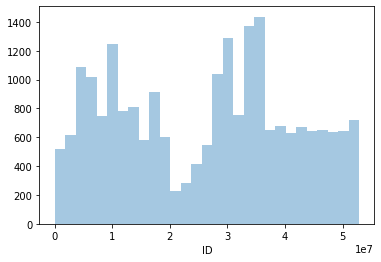

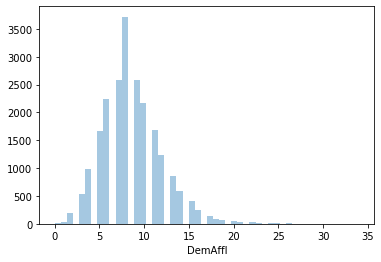

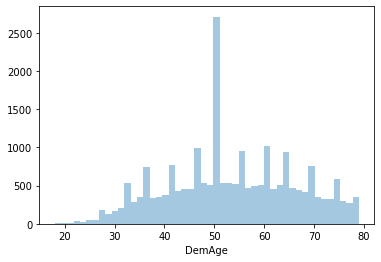

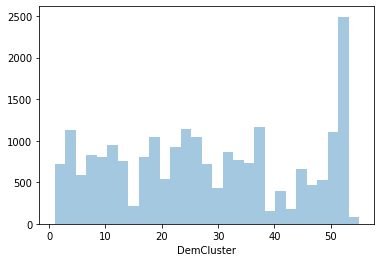

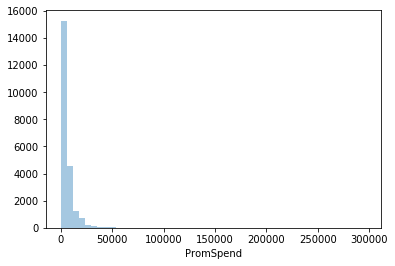

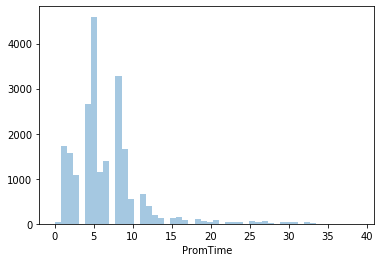

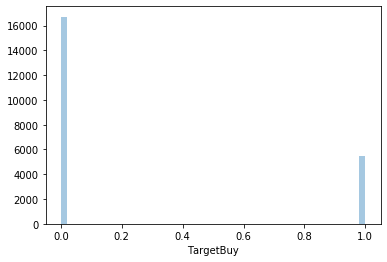

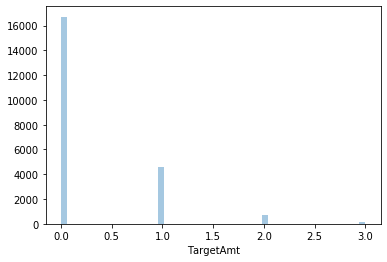

In [20]:
for i in data.var().index:
    sns.distplot(data[i],kde=False)
    plt.show()

Так же можно удалить столбец TargetAmt, так как количество приобритенных продуктов не потребуется нам дальше для анализа

In [21]:
data = data.drop(columns=['TargetAmt'])

Удалим стобец Id, так как ид клиента не понадобится на в будущем 

In [24]:
data = data.drop(columns=['ID'])

Проведем Бивариантный анализ Корреляция – связь между двумя метрическими переменными. При построении корреляции, мы ищем признаки, зависимые друг от друга или каким-либо образом влияющие на значения друг друга. Коэффициент корреляции признака с самим собой всегда равен единице, это значение не должно учитываться при исследовании зависимостей. Удобное представление коэффициентов корреляции - тепловая карта, представленная ниже:

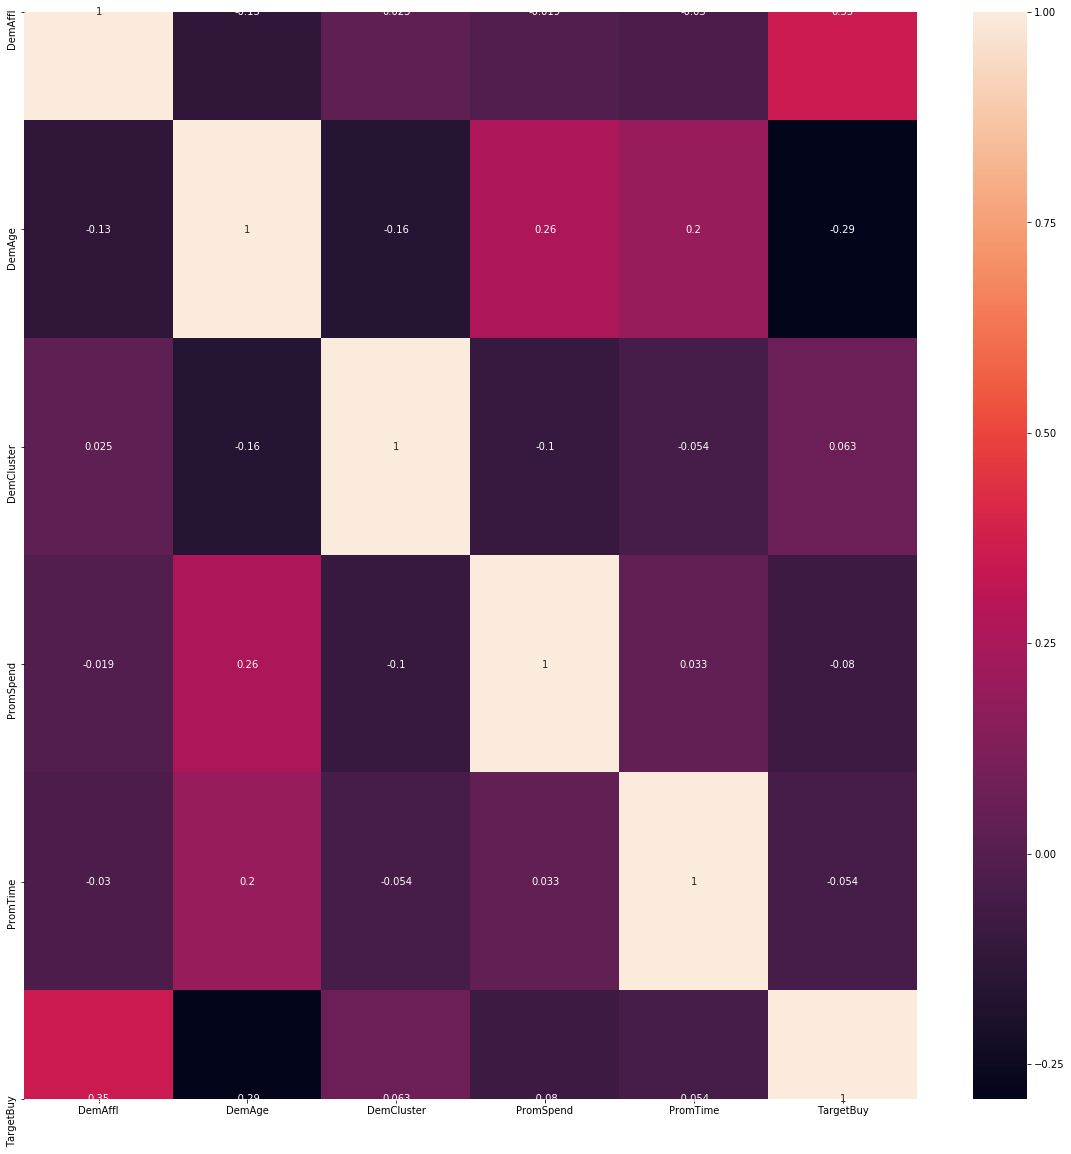

In [25]:
plt.figure(figsize=(20, 20))
correlation_matrix = data.corr()  
sns.heatmap(correlation_matrix, annot=True)
plt.show()

Посмотрим, какие факторы больше всего влеяют на TargetBuy(был ли куплен товар)

In [26]:
c_target = abs(correlation_matrix['TargetBuy'])
rf = c_target[c_target >= 0.2].drop('TargetBuy')
print(rf)

DemAffl    0.349522
DemAge     0.291768
Name: TargetBuy, dtype: float64


Проведя анализ, мы видим, что DemAffl - уровень дохода клиента (от 1 до 30), DemAge - возраст клиента больше всего влияют на покупку новой линейки органических продуктов.

Пришло время для определения моделей классификации. Возьмем несколько различных алгоритмов и сравним результаты их работы при помощи характеристики Area Under ROC Curve (auc). 
Сначала введем некоторые определения.
ROC кривая - график, который позволяет оценить качество бинарной классификации. График показывает зависимость TPR(полноты (показывает, сколько от общего числа реальных позитивных объектов, было предсказано, как позитивный класс.)) от FPR(показывает, сколько от общего числа реальных негативных объектов, оказались предсказанными неверно.) при варьировании порога.
AUC -  площадь, ограниченная ROC-кривой и осью доли ложных положительных классификаций. Чем выше показатель AUC, тем качественнее классификатор, при этом значение 0,5 демонстрирует непригодность выбранного метода классификации (соответствует случайному гаданию). Значение менее 0,5 говорит, что классификатор действует с точностью до наоборот: если положительные назвать отрицательными и наоборот, классификатор будет работать лучше.


In [ ]:
Для моделирования будут рассмотрены следующие алгоритмы:
    Decision Tree (entropy)
    Decision Tree (gini)
    Random Forest (entropy)
    Random Forest (gini)
    Bagging
    Gradient Boosting
    Linear Discriminant Analysis
    Logistic Regression